In [17]:
import jax
jax.config.update("jax_enable_x64", True)

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from model.drone_model_jax import get_default_params, pack_params, IDX
from utils.swarm_utils import assemble_swarm, swarm_evalf, swarm_compute_jacobian_jax

def get_simulation_setup():
    p = get_default_params()
    p_tuple = pack_params(p)
    targets = [(1.0, 1.0)]
    X0_flat, U = assemble_swarm(targets)
    return X0_flat, p_tuple, U

def step_euler(x, dt, p_tuple, U):
    dxdt = swarm_evalf(x, p_tuple, U)
    return x + dxdt * dt

def step_rk4(x, dt, p_tuple, U):
    k1 = swarm_evalf(x, p_tuple, U)
    k2 = swarm_evalf(x + 0.5 * dt * k1, p_tuple, U)
    k3 = swarm_evalf(x + 0.5 * dt * k2, p_tuple, U)
    k4 = swarm_evalf(x + dt * k3, p_tuple, U)
    return x + (dt / 6.0) * (k1 + 2 * k2 + 2 * k3 + k4)

def step_trap(x, dt, p_tuple, U):
    tol = 1e-10
    max_iter = 100
    I = np.eye(len(x))
    
    f_curr = swarm_evalf(x, p_tuple, U)
    x_next = x + f_curr * dt
    
    for _ in range(max_iter):
        f_next = swarm_evalf(x_next, p_tuple, U)
        residual = x_next - x - (dt / 2.0) * (f_curr + f_next)
        
        if np.linalg.norm(residual) < tol:
            break
            
        J_f = swarm_compute_jacobian_jax(x_next, p_tuple, U)
        if np.isnan(J_f).sum() > 0:
            break
            
        J_G = I - (dt / 2.0) * J_f
        delta = np.linalg.solve(J_G, -residual)
        x_next += delta
        
    return x_next

def run_simulation(step_fn, x0, dt, T_final, p_tuple, U):
    X = [x0.copy()]
    T = [0]
    x = x0.copy()
    steps = int(T_final / dt)
    for i in range(steps):
        x = step_fn(x, dt, p_tuple, U)
        X.append(x)
        T.append((i+1)*dt)
    return x, np.array(X), np.array(T)

X0, p_tuple, U = get_simulation_setup()
T_final = 1.0

dt_ref = 1e-4
x_ref, X_ref, T_ref = run_simulation(step_rk4, X0, dt_ref, T_final, p_tuple, U)

In [11]:
dts = np.arange(1e-3, 3.01e-2, 2e-3)
methods = {
    'Euler': step_euler,
    'Trapezoidal': step_trap,
    'RK4': step_rk4
}

errors = {name: [] for name in methods}
for dt in tqdm(dts):
    for name, func in methods.items():
        x_final, _, _ = run_simulation(func, X0, dt, T_final, p_tuple, U)
        error = np.max(np.abs(x_final - x_ref))
        errors[name].append(error)

100%|███████████████████████████████| 15/15 [00:09<00:00,  1.61it/s]


In [18]:
plt.figure(figsize=(10, 6))
for name, err_list in errors.items():
    plt.plot(dts, err_list, 'o-', label=name)
plt.xscale('log')
plt.yscale('log')
plt.ylim([1e-5, 1e10])
plt.xlabel('Time Step (dt)')
plt.ylabel('Error (vs Reference)')
plt.title('Solver Convergence Analysis')
plt.grid(True, which="both", ls="-", alpha=0.5)
plt.legend()
plt.show()

AttributeError: 'list' object has no attribute 'items'

<Figure size 1000x600 with 0 Axes>

# Dynamic

In [6]:
def get_ref_state(t, T_ref, X_ref):
    dt = T_ref[1] - T_ref[0]
    
    # find index
    idx = int(t / dt)
    
    # edge case
    if idx >= len(T_ref) - 1:
        return X_ref[-1]
    
    # interpolation
    t_low = T_ref[idx]
    alpha = (t - t_low) / dt
    
    x_interp = (1 - alpha) * X_ref[idx] + alpha * X_ref[idx+1]
    return x_interp

    
def run_dynamic_simulation(step_fn, x0, T_final, p_tuple, U, T_ref, X_ref, tol_error=0.1):
    x = x0.copy()
    t = 0.0
    dt = 1e-4
    dt_min = 1e-4
    dt_max = 1e-2
    
    history_dt = []
    while t < T_final:
        # 0. Adjust
        if t + dt > T_final:
            dt = T_final - t  # s.t., t+dt == T_final

        # 1. Step
        x_next_candidate = step_fn(x, dt, p_tuple, U)

        # 2. Get Ref
        x_true = get_ref_state(t + dt, T_ref, X_ref)
        
        # 3. Compute Error
        error = np.max(np.abs(x_next_candidate - x_true))
        
        # 4. Check against Tolerance (e_a)
        if error > tol_error:
            # REJECT: Error > tolerance
            if dt == dt_min:
                x = x_next_candidate
                t += dt
                history_dt.append(dt)
            else:
                dt -= 1e-3

                dt = max(dt, dt_min)
        else:
            # ACCEPT: Error <= tolerance
            x = x_next_candidate
            t += dt
            history_dt.append(dt)
            
            dt += 1e-3
            dt = min(dt, dt_max)
    return x, history_dt

In [7]:
x_final, history_dt = run_dynamic_simulation(step_rk4, X0, T_final, p_tuple, U, T_ref, X_ref, tol_error=1e-2)

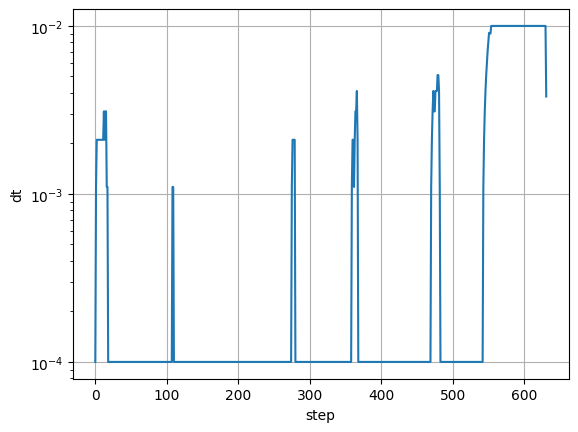

In [8]:
plt.figure()
plt.plot(history_dt)
plt.yscale('log')
plt.xlabel('step')
plt.ylabel('dt')
plt.grid()
plt.show()

Solving Steady State...
Steady State y: 1.000000
Running Trapezoidal Simulation...
Running Forward Euler Simulation...
----------------------------------------
Method          | Final Position  | Final Error
----------------------------------------
Trapezoidal     | 1.000000        | -6.183942e-14
Forward Euler   | 1.000000        | -6.206147e-14
----------------------------------------


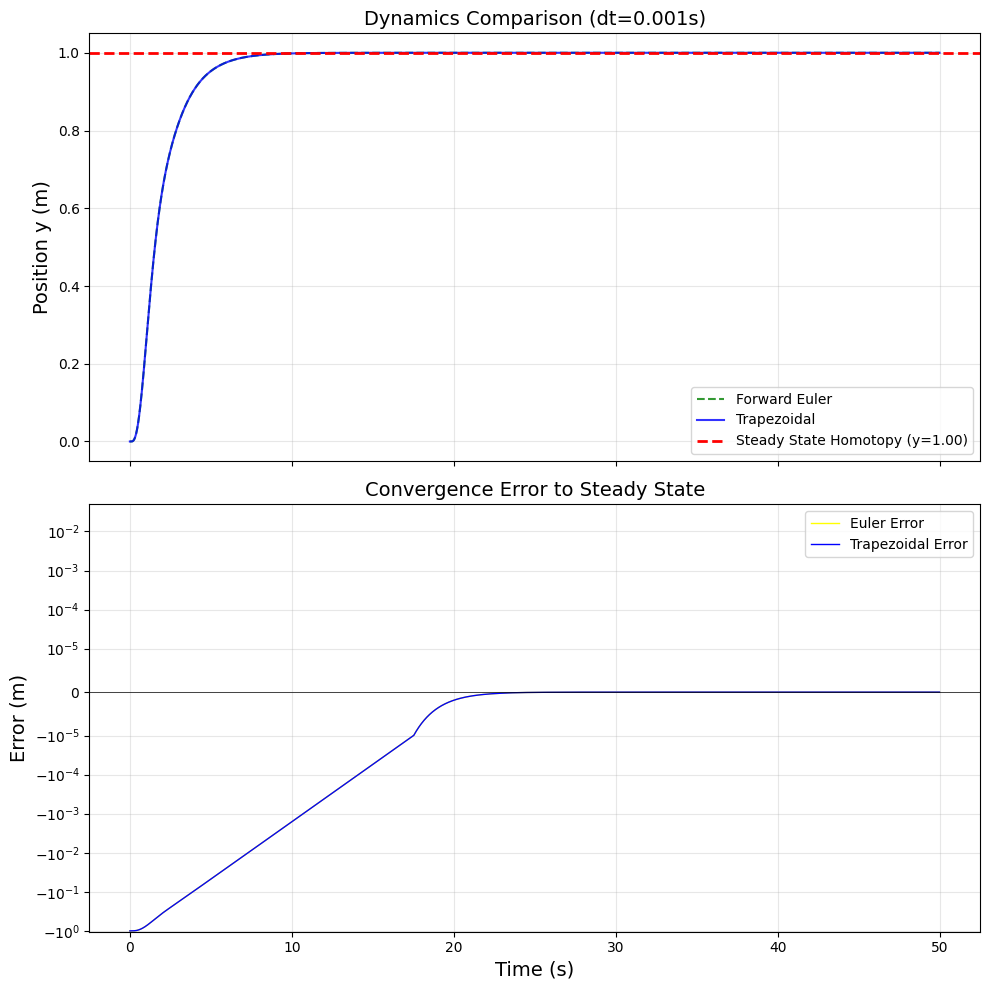

In [23]:
# COMPARISON: TRAPEZOIDAL vs. FORWARD EULER vs. HOMOTOPY STEADY STATE
import numpy as np
import matplotlib.pyplot as plt
import jax.numpy as jnp

# 1. Imports
from model.drone_model_jax import get_default_params, pack_params, N_STATES, IDX
from steady_state_homotopy_LU import homotopy_solve
from utils.swarm_utils import swarm_evalf  # Required for your step_euler

# 3. Setup Parameters
p = get_default_params()
p_tuple = pack_params(p)
u_target = np.array([1.0, 1.0]) # Target: y=1.0, z=1.0
x0 = np.zeros(N_STATES)         # Initial: Rest

# ------------------------------------------------------------------
# 4. SOLVE STEADY STATE (Reference)
# ------------------------------------------------------------------
print("Solving Steady State...")
# homotopy_solve expects single u input: shape (2,)
x_ss, path = homotopy_solve(
    x0,
    p_tuple,
    u_target,
    tau_start=0.0,
    tau_end=1.0,
    verbose=False
)
y_ss = x_ss[IDX['y']]
print(f"Steady State y: {y_ss:.6f}")

# ------------------------------------------------------------------
# 5. RUN SIMULATIONS
# ------------------------------------------------------------------
dt = 0.001
T_final = 50.0  # Long duration to settle transients
steps = int(T_final / dt)
time_grid = np.linspace(0, T_final, steps + 1)

# Swarm evalf requires U shape (N, 2), so we wrap u_target
U_swarm = np.array([u_target])

# --- Simulation A: Trapezoidal ---
print("Running Trapezoidal Simulation...")
x_curr_trap = np.zeros(N_STATES)
y_traj_trap = [x_curr_trap[IDX['y']]]

for _ in range(steps):
    x_curr_trap = step_trap(x_curr_trap, dt, p_tuple, U_swarm)
    y_traj_trap.append(x_curr_trap[IDX['y']])

# --- Simulation B: Forward Euler ---
print("Running Forward Euler Simulation...")
x_curr_euler = np.zeros(N_STATES)
y_traj_euler = [x_curr_euler[IDX['y']]]

for _ in range(steps):
    x_curr_euler = step_euler(x_curr_euler, dt, p_tuple, U_swarm)
    # Ensure result is numpy for plotting/storage consistency
    if hasattr(x_curr_euler, 'block_until_ready'): # is JAX array
        x_curr_euler = np.array(x_curr_euler)
    y_traj_euler.append(x_curr_euler[IDX['y']])

# ------------------------------------------------------------------
# 6. CALCULATE ERRORS
# ------------------------------------------------------------------
error_trap = np.array(y_traj_trap) - y_ss
error_euler = np.array(y_traj_euler) - y_ss

print("-" * 40)
print(f"{'Method':<15} | {'Final Position':<15} | {'Final Error'}")
print("-" * 40)
print(f"{'Trapezoidal':<15} | {y_traj_trap[-1]:<15.6f} | {error_trap[-1]:.6e}")
print(f"{'Forward Euler':<15} | {y_traj_euler[-1]:<15.6f} | {error_euler[-1]:.6e}")
print("-" * 40)

# ------------------------------------------------------------------
# 7. VISUALIZE
# ------------------------------------------------------------------
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10), sharex=True)

# Plot 1: Trajectories
ax1.plot(time_grid, y_traj_euler, label='Forward Euler', linestyle='--', color='green', linewidth=1.5, alpha=0.8)
ax1.plot(time_grid, y_traj_trap, label='Trapezoidal', color='blue', linewidth=1.5, alpha=0.8)
ax1.axhline(y=y_ss, color='r', linestyle='--', linewidth=2, label=f'Steady State Homotopy (y={y_ss:.2f})')
ax1.set_ylabel('Position y (m)', fontsize=14)
ax1.set_title(f'Dynamics Comparison (dt={dt}s)', fontsize=14)
ax1.grid(True, alpha=0.3)
ax1.legend(loc='lower right')

# Plot 2: Errors
ax2.plot(time_grid, error_euler, label='Euler Error', color='green', linewidth=1)
ax2.plot(time_grid, error_trap, label='Trapezoidal Error', color='blue', linewidth=1)
ax2.axhline(y=0, color='k', linestyle='-', linewidth=0.5)
ax2.set_xlabel('Time (s)', fontsize=14)
ax2.set_ylabel('Error (m)', fontsize=14)
ax2.set_title('Convergence Error to Steady State', fontsize=14)
ax2.set_yscale('symlog', linthresh=1e-5)
ax2.grid(True, alpha=0.3, which='both')
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()

dt         | Final Error     | Ratio
----------------------------------------
1e-02      | 6.231857e-03    | -
5e-03      | 6.231008e-03    | 1.00
1e-03      | 6.230469e-03    | 1.00
5e-04      | 6.230461e-03    | 1.00


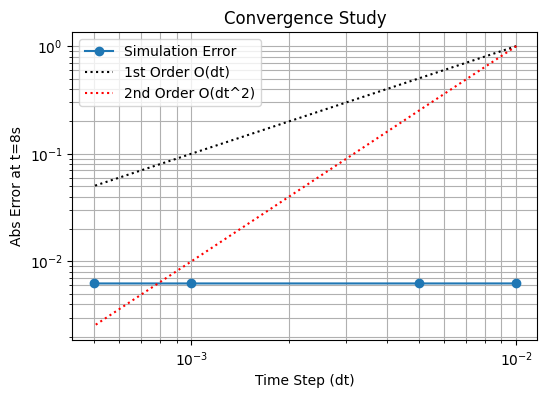

In [11]:
x_ss, path = homotopy_solve(x0, p_tuple, u_target, verbose=False)
y_ss = x_ss[IDX['y']]

# 2. Run Convergence Loop
dt_values = [1e-2, 5e-3, 1e-3, 5e-4]
errors = []

print(f"{'dt':<10} | {'Final Error':<15} | {'Ratio'}")
print("-" * 40)

for i, dt in enumerate(dt_values):
    steps = int(8.0 / dt)
    x_curr = np.zeros(N_STATES)
    U_swarm = np.array([u_target])

    for _ in range(steps):
        x_curr = step_trap(x_curr, dt, p_tuple, U_swarm)

    final_pos = x_curr[IDX['y']]
    err = abs(final_pos - y_ss)
    errors.append(err)

    # Calculate convergence ratio (Error_prev / Error_curr)
    if i > 0:
        ratio = errors[i-1] / err
        ratio_str = f"{ratio:.2f}"
    else:
        ratio_str = "-"

    print(f"{dt:<10.0e} | {err:<15.6e} | {ratio_str}")

# 3. Plot Convergence
plt.figure(figsize=(6, 4))
plt.loglog(dt_values, errors, 'o-', label='Simulation Error')
# Reference lines for O(dt) and O(dt^2)
plt.loglog(dt_values, [100*x for x in dt_values], 'k:', label='1st Order O(dt)')
plt.loglog(dt_values, [10000*x**2 for x in dt_values], 'r:', label='2nd Order O(dt^2)')

plt.xlabel('Time Step (dt)')
plt.ylabel('Abs Error at t=8s')
plt.title('Convergence Study')
plt.grid(True, which="both", ls="-")
plt.legend()
plt.show()